In [1]:
import numpy as np
from pyomo.environ import *
from numpy.linalg import inv
from numpy import linalg as LA
from numpy.linalg import inv
import matplotlib.pyplot as plt
import proyecciones as pro
import time

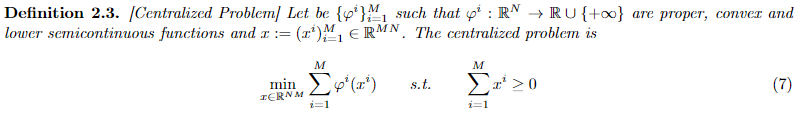

Nuestro objetivo es implementar una solución en pyomo que resuelva (8), esto es considerando el siguiente ejemplo:

In [19]:
from pyomo.environ import *

N = 3
M = 5

model = ConcreteModel("Centralized Problema")

model.I  = range(N)
model.XI = range(M)


# Probabilidades:
if 0:
    Sigma = np.random.random((1,M))
    Sigma /= Sigma.sum()
else:
    Sigma = np.ones((1,M)) 
    Sigma /= Sigma.shape[1] 
    
#Sigma = list(Sigma[0])
Sigma = [0.24742314, 0.14185111, 0.11520659, 0.19543994, 0.30007922]
#[0.24742314, 0.14185111, 0.11520659, 0.19543994, 0.30007922]
print(Sigma)

# Parámetros funciones:
I    = [50 for i in range(N)]
MC   = [[1000 for xi in range(M)] for i in range(N)]

VOLL = 10000
D    = [1000 for xi in range(M)]

model.x1 = Var(model.I,           within = NonNegativeReals)
model.x2 = Var(model.I, model.XI, within = NonNegativeReals)
model.x3 = Var(model.XI,          within = NonNegativeReals)

model.CAPACIDAD_PRODUCCION = ConstraintList()

for xi in model.XI:
    for i in model.I:
        model.CAPACIDAD_PRODUCCION.add(0 <= model.x1[i] - model.x2[i,xi] )
        
model.EQUILIBRIO = ConstraintList()

for xi in model.XI:
    model.EQUILIBRIO.add( 0 <= sum(model.x2[i,xi] for i in model.I) - (D[xi] - model.x3[xi]) ) 
    
model.DEMANDA = ConstraintList()

for xi in model.XI:
    model.DEMANDA.add( model.x3[xi] <= D[xi] )
    

model.dual = Suffix(direction=Suffix.IMPORT_EXPORT)
    
model.obj = Objective( expr = sum(I[i]*model.x1[i] for i in model.I)                                                      \
                            + sum(Sigma[xi]*0.005*sum(MC[i][xi]*(model.x2[i,xi]**2) for i in model.I) for xi in model.XI) \
                            + sum(Sigma[xi]*(-1)*VOLL*(D[xi]-model.x3[xi]) for xi in model.XI)                                 )

[0.24742314, 0.14185111, 0.11520659, 0.19543994, 0.30007922]


In [16]:
opt = SolverFactory('ipopt')
result = opt.solve(model, tee=True) 

model.display()

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       55
Number of nonzeros in Lagrangian Hessian.............:       15

Total number of variables............................:       23
                     variables with only lower bounds:       23
                variables with lower and upper bounds:        0


In [17]:
model.dual.display()

dual : Direction=Suffix.IMPORT_EXPORT, Datatype=Suffix.FLOAT
    Key                      : Value
    CAPACIDAD_PRODUCCION[10] :     10.823638990407572
    CAPACIDAD_PRODUCCION[11] :     10.823638990407606
    CAPACIDAD_PRODUCCION[12] :     10.823638990407652
    CAPACIDAD_PRODUCCION[13] :     10.373682869778236
    CAPACIDAD_PRODUCCION[14] :     10.373682869778253
    CAPACIDAD_PRODUCCION[15] :     10.373682869778126
     CAPACIDAD_PRODUCCION[1] :     10.999425409814863
     CAPACIDAD_PRODUCCION[2] :     10.999425409814805
     CAPACIDAD_PRODUCCION[3] :     10.999425409814826
     CAPACIDAD_PRODUCCION[4] :      8.485144788158985
     CAPACIDAD_PRODUCCION[5] :      8.485144788158985
     CAPACIDAD_PRODUCCION[6] :      8.485144788159007
     CAPACIDAD_PRODUCCION[7] :      9.318107941615503
     CAPACIDAD_PRODUCCION[8] :       9.31810794161552
     CAPACIDAD_PRODUCCION[9] :      9.318107941615557
                  DEMANDA[1] : -7.444498635572993e-11
                  DEMANDA[2] : -7.4444

In [18]:
# Verifica si la solución fue exitosa
if result.solver.status == SolverStatus.ok:
    # Extrae los valores de las variables de decisión y los almacena en listas
    x1_values = [model.x1[i].value for i in model.I]
    x2_values = [[model.x2[i, xi].value for i in model.I] for xi in model.XI]
    x3_values = [model.x3[xi].value for xi in model.XI]

    dual_value_equilibrio = [model.dual[model.EQUILIBRIO[xi+1]] for xi in model.XI]  # Suponiendo que hay solo una restricción con ese nombre

    

    # Ahora 'x1_values', 'x2_values', y 'x3_values' contienen las soluciones en forma de listas
    print("Soluciones:")
    print("x1:", x1_values)
    print("x2:", x2_values)
    print("x3:", x3_values)
    print("Valor dual de la restricción 'EQUILIBRIO':", dual_value_equilibrio)
    
else:
    print("El solver no encontró una solución óptima.")


Soluciones:
x1: [333.3333300008733, 333.3333300008733, 333.3333300008733]
x2: [[333.33333000334807, 333.33333000334807, 333.33333000334807], [333.33333000335847, 333.33333000335847, 333.3333300033584], [333.3333300033639, 333.3333300033639, 333.3333300033639], [333.3333300033519, 333.3333300033519, 333.3333300033519], [333.33333000334557, 333.33333000334557, 333.33333000334557]]
x3: [0.0, 0.0, 0.0, 0.0, 0.0]
Valor dual de la restricción 'EQUILIBRIO': [835.7432171704359, 481.3221733976612, 393.3400707717131, 662.2900991487356, 1010.6377395436187]
